<a href="https://colab.research.google.com/github/hkbu-kennycheng/comp3057/blob/main/lab2_image_classification_and_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification

We are going to train an image classification models with `PyTorch`. Let's import `torch` first.

In [ ]:
import torch

## Dataset: [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)

With `Fashion MNIST` dataset, we could train a model to classify cloth image.

![](https://url2img-web.herokuapp.com/aHR0cHM6Ly9naXRodWIuY29tL3phbGFuZG9yZXNlYXJjaC9mYXNoaW9uLW1uaXN0I2Zhc2hpb24tbW5pc3Q=?w=1280&h=800)

### Why Fashion MNIST?

Orignal [MNIST dataset](http://yann.lecun.com/exdb/mnist/) is a dataset of  handwritten digits. Because of its simplicty, the machine learning community would use MNIST dataset to validate their algorithms at the very begining during development. But it's too easy for the algorithms nowadays and could not represent modern computer vision tasks.

`Fashion MNIST` serve the same purpose as orignal MNIST dataset and could be used as a drop-in replacement.

### Loading Fashion MNIST with torchvision

`Fashion MNIST` could be downloaded with `torchvision` module directly by `torchvision.datasets`. We also need `torchvision.transforms` for scaling up images to `32x32` and transform data to [`Tensor`](https://pytorch.org/docs/stable/tensors.html). Tensor is a multi-dimensional container for data of different types.


In [ ]:
from torchvision import datasets
from torchvision import transforms

train_set = datasets.FashionMNIST("./data", download=True,
                                  transform=transforms.Compose([transforms.ToTensor()]))
test_set = datasets.FashionMNIST("./data", download=True, train=False,
                                 transform=transforms.Compose([transforms.ToTensor()]))

### Split train, valid and test data

By wrapping data with `DataLoader`, it helps us to shuffle and load data in each iteration during the train process.

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, shuffle=True)
test_loader = DataLoader(test_set, shuffle=True)

The labels are represented using `0 - 9`.

In [ ]:
labels = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

## Building a sequential model

A sequential model is a stack of layers, where each layer has only one input tensor and output tensor.





### Model architecture

Here is an overview of our first model that we are going to build in this lab. It takes a single input (a single channel image) and provide a output (probability of labels). 

```
 +---------+    +--------+    +------+    +--------+
 | Flatten | -> | Linear | -> | ReLu | -> | Linear |
 +---------+    +--------+    +------+    +--------+
```

Flatten layer reformats the input data from 2d array `(28, 28)` to 1d array `(784)`, which has no parameters to learn.

`Linear -> ReLu -> Linear` is a fully-connected `ReLU` network with one hidden layer, which consits of `128` nodes (or neurons). It accepts `784` inputs and provide `10` output for corresponding label probabilities.



In [ ]:
from torch import nn

model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(784, 128),
  nn.ReLU(),
  nn.Linear(128, 10),
)

## Train the mdoel


### Define loss function

Loss function measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.

We would use [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in our example model.

In [ ]:
loss_function = nn.CrossEntropyLoss()

### Specifying Optimizer

This is how the model is updated based on the data it sees and its loss function. SDG is a gradient descent (with `momentum` set to `0.9`) optimizer. For learning rate, we set to `0.001`.

In [ ]:
from torch import optim

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

### Define epoch number

We first need to define how many `epoch` in the training process. An epoch means one complete pass of the training dataset through the algorithm. Each epoch takes a few minutes running on Colab CPU runtime in our model.

In [ ]:
NUM_EPOCHS = 1

### Putting together in the loop



In [ ]:
from tqdm import tqdm # for showing as progress bar

model.train() # put model in training mode

for epoch in range(NUM_EPOCHS):

  loop = tqdm(train_loader, position=0, leave=True)

  for (input, label) in loop:
    optimizer.zero_grad() # zero the parameter gradients

    # forward + backward + optimize
    output = model.forward(input)
    loss = loss_function(output, label)
    loss.backward()
    optimizer.step()
    
    loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")

Epoch [0/1]: 100%|██████████| 60000/60000 [06:57<00:00, 143.78it/s]


## Saving and loading model

It's easy to store the trained model and load it back in `PyTorch`.

### Save

You could output trained model as a single file with `torch.save`, which contains all `parameters` of the model.

In [ ]:
PATH = './FashionMNIST_net.pth'
torch.save(model.state_dict(), PATH)

### Load

To load it back, we need to construct the corresponding model, and invoke `model.load_state_dict` by passing in the model file loaded with `torch.load`.

In [ ]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Make prediction using the trained model

### Convert logits to probabilities

With the model trained, you can use it to make predictions about some images. The model's linear outputs, logits. Attach a softmax layer to convert the logits to probabilities, which are easier to interpret. 

In [ ]:
model.add_module('output', nn.Softmax())

### Interpret prediction result

In following example, we take the first data from test set and pass it the `model.forward` for prediction. It would return probabilities of the corresponding label by index.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([3.9156e-02, 5.9873e-04, 2.8378e-01, 6.8127e-02, 1.1522e-01, 1.3620e-04,
        4.9051e-01, 4.5853e-04, 1.8333e-03, 1.8233e-04],
       grad_fn=<SelectBackward>)
Ground truth label: Shirt
Probability for the ground truth: 0.49050724506378174


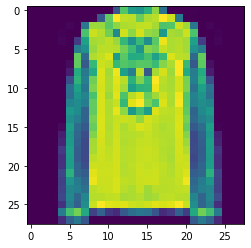

In [ ]:
model.eval() # put model in evaluation mode

img, label = next(iter(test_loader))
output = model.forward(img)
print(output[0]) # probabilities for each label

print(f'Ground truth label: {labels[int(label[0])]}')
print(f'Probability for the ground truth: {output[0][label[0]]}')

import matplotlib.pyplot as plt
plt.imshow(transforms.ToPILImage()(img[0]))

## Test trained model

To measure the trained model performance, we will need to make prediction using test set and calculate the accuracy.

### Calculate average accuracy

In [ ]:
correct = 0
total = 0

loop = tqdm(test_loader, position=0, leave=True)
model.eval() # put model in evaluation mode
for (input, label) in loop:
  output = model.forward(input)
  _, predicted = torch.max(output.data, 1)
  total += label.size(0)
  correct += (predicted == label).sum().item()
  loop.set_postfix(acc=(100*correct/total))

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 10000/10000 [00:40<00:00, 249.62it/s, acc=84.8]


# Clustering with K-means

The second task for this lab is to clustering data with `kmeans`.


Let's install `kmeans-pytorch` module with `pip` command. It's a k-means implementation with GPU support.

In [ ]:
!pip install kmeans-pytorch

## Prepare data

To use `kmeans_pytorch`, simply import `kmeans` from `kmeans_pytorch`. It only support clustering 2d data, thus we need to flatten our dataset to a 2d tensor. We only take the first 10000 data in the dataset.



In [ ]:
import numpy as np
from kmeans_pytorch import kmeans, kmeans_predict

x = torch.flatten(train_loader.dataset.data[:10000], 1)

### Running kmeans

To run kmeans, we need to pass in the data and number of cluster. The default configuration use euclidean distance to calculate distance between data points. You could change to cosine by passing in `distance='cosine'`.

In [ ]:
cluster_ids_x, cluster_centers = kmeans(X=x, num_clusters=10)

After running kmeans, we could get the cluster IDs and centroid of each cluster.

In [ ]:
print(cluster_ids_x)
print(cluster_centers)

tensor([8, 1, 4,  ..., 0, 4, 9])
tensor([[0.0000e+00, 1.0638e-03, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.1461e-02, 2.8653e-02, 1.7335e-01,  ..., 7.1633e-02, 2.2923e-02,
         7.1633e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.3834e-02, 1.0363e-02,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.1497e+01, 5.1812e+00,
         5.1453e-01],
        [1.0941e-03, 1.4223e-02, 5.0328e-02,  ..., 9.4475e+00, 1.2954e+00,
         6.5646e-03]])


### Interpret the results

To visualize cluster_centers value, we could restore it as 28x28 array by `reshape`. Which same as undo the flatten operation that we have done.

So that we could show the images using `matplotlib`. In the following result, we could able identify the centroid of Ankle boot and Trouser.

torch.Size([10, 784])


<Figure size 432x288 with 0 Axes>

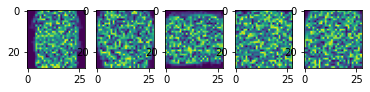

<Figure size 432x288 with 0 Axes>

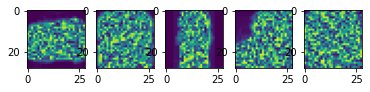

In [ ]:
print(cluster_centers.shape)
cluster_centers_images = torch.reshape(cluster_centers, (10, 28, 28))

plt.figure()
f, ax = plt.subplots(1,5)
for i in range(5):
  ax[i].imshow(transforms.ToPILImage()(cluster_centers_images[i]))

plt.figure()
f, ax = plt.subplots(1,5)
for i in range(5):
  ax[i].imshow(transforms.ToPILImage()(cluster_centers_images[5+i]))

### Make prediction

After we have a cluster, we could use it to classify unseen data by using `kmeans_predict`.

In [ ]:
y = torch.flatten(test_loader.dataset.data, 1)

cluster_ids_y = kmeans_predict(y, cluster_centers)

predicting on cpu..


tensor([5, 9, 7,  ..., 4, 7, 5])


<Figure size 432x288 with 0 Axes>

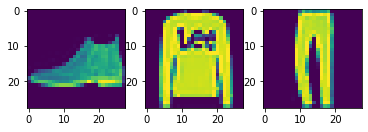

In [ ]:
print(cluster_ids_y)
plt.figure()
f, ax = plt.subplots(1,3)
for i in range(3):
  ax[i].imshow(transforms.ToPILImage()(test_loader.dataset.data[i]))